## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
from tensorflow import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [9]:
train, test = keras.datasets.cifar10.load_data()

In [10]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [11]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128], drop_ratio = 0.2,
              regularizer = l1, regularizer_ratio = 0.5):
    """Code Here
    建立你的神經網路
    """

    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i ==0:
            x = keras.layers.Dense(units = n_units,
                                   activation = 'relu',
                                   name = 'hidden_layer' + str(i+1),
                                   kernel_regularizer=regularizer(regularizer_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units = n_units,
                                  activation = 'relu',
                                  name = 'hidden_layer' + str(i+1),
                                  kernel_regularizer=regularizer(regularizer_ratio))(x)
            x = Dropout(drop_ratio)(x)
        
    out = keras.layers.Dense(units = output_units, activation = 'softmax', name = 'output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])


    return model

In [13]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 20
MOMENTUM = 0.95

Batch_size = [32, 128, 256]
Drop_ratio = [0.25,0.1,0.5,0.7]
Regularizer_Function = [l1, l2]
Regularizer_Ratio = [1e-2, 1e-4, 1e-8]

In [15]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for batch_size,drop_ratio,reg_fun,reg_ratio in itertools.product(Batch_size, Drop_ratio, Regularizer_Function, Regularizer_Ratio):
    keras.backend.clear_session()
    print(f'Experiment with Batch_size = {batch_size}, Drop_ratio = {drop_ratio}, Regularizer_Function={reg_fun}, Regularizer_Ratio={reg_ratio}')
    model = build_mlp(input_shape=x_train.shape[1:], drop_ratio = drop_ratio, regularizer = reg_fun, regularizer_ratio = reg_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train,y_train,
              epochs = EPOCHS,
              batch_size = batch_size,
              validation_data = (x_test, y_test),
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['accuracy']
    valid_acc = model.history.history['val_accuracy']

    exp_name_tag = f'batch_size-{batch_size}-drop_ratio-{drop_ratio}-reg_fun-{reg_fun}-reg_ratio-{reg_ratio}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc' : train_acc,
                             'val-acc'   : valid_acc}

Experiment with Batch_size = 32, Drop_ratio = 0.25, Regularizer_Function=<class 'keras.regularizers.L1'>, Regularizer_Ratio=0.01
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896    

IndexError: list index out of range

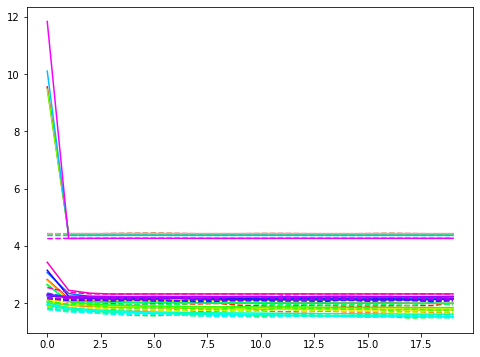

In [27]:
from matplotlib import cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
"""Code Here
將結果繪出
"""

NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(20,15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['val-acc'])),results[cond]['val-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [24]:
results.keys()

dict_keys(["batch_size-32-drop_ratio-0.25-reg_fun-<class 'keras.regularizers.L1'>-reg_ratio-0.01", "batch_size-32-drop_ratio-0.25-reg_fun-<class 'keras.regularizers.L1'>-reg_ratio-0.0001", "batch_size-32-drop_ratio-0.25-reg_fun-<class 'keras.regularizers.L1'>-reg_ratio-1e-08", "batch_size-32-drop_ratio-0.25-reg_fun-<class 'keras.regularizers.L2'>-reg_ratio-0.01", "batch_size-32-drop_ratio-0.25-reg_fun-<class 'keras.regularizers.L2'>-reg_ratio-0.0001", "batch_size-32-drop_ratio-0.25-reg_fun-<class 'keras.regularizers.L2'>-reg_ratio-1e-08", "batch_size-32-drop_ratio-0.1-reg_fun-<class 'keras.regularizers.L1'>-reg_ratio-0.01", "batch_size-32-drop_ratio-0.1-reg_fun-<class 'keras.regularizers.L1'>-reg_ratio-0.0001", "batch_size-32-drop_ratio-0.1-reg_fun-<class 'keras.regularizers.L1'>-reg_ratio-1e-08", "batch_size-32-drop_ratio-0.1-reg_fun-<class 'keras.regularizers.L2'>-reg_ratio-0.01", "batch_size-32-drop_ratio-0.1-reg_fun-<class 'keras.regularizers.L2'>-reg_ratio-0.0001", "batch_size-32-